In [14]:
# pip install geopandas

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (5.3 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.11.1-cp313-cp313-macosx_12_0_arm64.whl (19.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geopandas]━ 1/2 [geopandas]
Note: you may need to restart the kernel to use updated packages.


In [17]:
# pip install geodatasets

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import pandas as pd
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [23]:
output_dir ='/Users/karenlovedorial/Library/CloudStorage/OneDrive-Personal/Data Sources'
tracks_path = os.path.join(output_dir, 'ibtracs.WP.list.v04r01.csv')

/Users/karenlovedorial/Library/CloudStorage/OneDrive-Personal/Data Sources/ibtracs.WP.list.v04r01.csv


In [24]:
tracks_df = pd.read_csv(tracks_path, skiprows=[1])
print(f"Number of columns: {len(tracks_df.columns)}")
print(tracks_df.columns)
tracks_df.head()

/var/folders/d4/d0bqhj656mz5rl__scl2bqrh0000gn/T/ipykernel_44345/51820887.py:1: DtypeWarning: Columns (19,20,23,24,142,143,144,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv(tracks_path, skiprows=[1])


Number of columns: 174
Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=174)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 16:00:00,NR,16.5,124.0,...,,,,,,,,,6,280
1,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 18:00:00,NR,16.5,123.8,...,,,,,,,,,6,280
2,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 21:00:00,NR,16.6,123.5,...,,,,,,,,,6,285
3,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 00:00:00,NR,16.7,123.2,...,,,,,,,,,6,285
4,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 03:00:00,NR,16.8,122.9,...,,,,,,,,,6,290


In [8]:
tracks_df["SEASON"].unique()

array([1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894,
       1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916,
       1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [12]:
tracks_df_2025 = tracks_df[tracks_df["SEASON"]==2025]
print(tracks_df_2025.shape)
tracks_df_2025.head()

(1211, 174)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
245329,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 12:00:00,NR,15.0,113.9,...,,,,,,,,,5,90
245330,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 15:00:00,NR,15.0,114.2,...,,,,,,,,,4,65
245331,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 18:00:00,NR,15.2,114.3,...,,,,,,,,,7,5
245332,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 21:00:00,NR,15.7,114.2,...,,,,,,,,,11,340
245333,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-11 00:00:00,NR,16.2,113.9,...,,,,,,,,,13,310


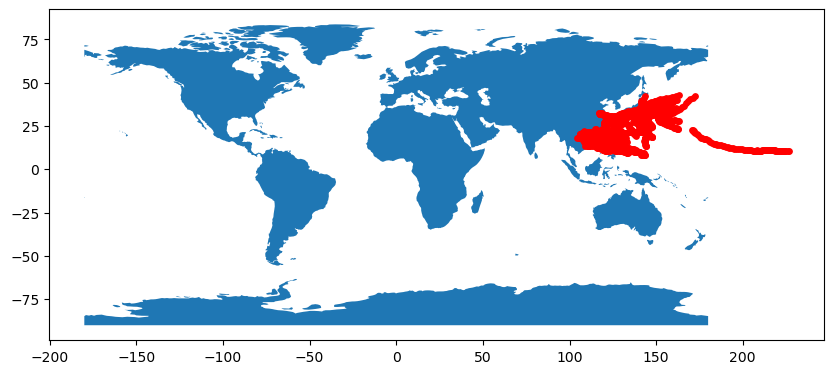

In [20]:
geometry = [Point(xy) for xy in zip(tracks_df_2025['LON'], tracks_df_2025['LAT'])]
gdf = GeoDataFrame(tracks_df_2025, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

# solution from: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6

In [26]:
tracks_df_2025.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
245329,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 12:00:00,NR,15.0,113.9,...,,,,,,,,,5,90
245330,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 15:00:00,NR,15.0,114.2,...,,,,,,,,,4,65
245331,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 18:00:00,NR,15.2,114.3,...,,,,,,,,,7,5
245332,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-10 21:00:00,NR,15.7,114.2,...,,,,,,,,,11,340
245333,2025162N15114,2025,32,WP,MM,WUTIP,2025-06-11 00:00:00,NR,16.2,113.9,...,,,,,,,,,13,310


In [28]:
destination_path = os.path.join(output_dir, 'ibtracs.WP.list.v04r01_2025.csv')
tracks_df_2025.to_csv(destination_path)
print("DONE!")

DONE!
